In [1]:
import numpy as np
import pandas as pd
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]= "true"
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
plt.style.use('ggplot') #グラフスタイル
plt.rcParams['figure.figsize'] = [20, 5] # グラフサイズ

In [2]:
## ラグ付きデータセット生成関数
def gen_dataset(dataset, lag_max):
    X, y = [], []
    for i in range(len(dataset) - lag_max):
        a = i + lag_max
        X.append(dataset[i:a, 0]) #ラグ変数
        y.append(dataset[a, 0])   #目的変数
    return np.array(X), np.array(y)

<AxesSubplot:>

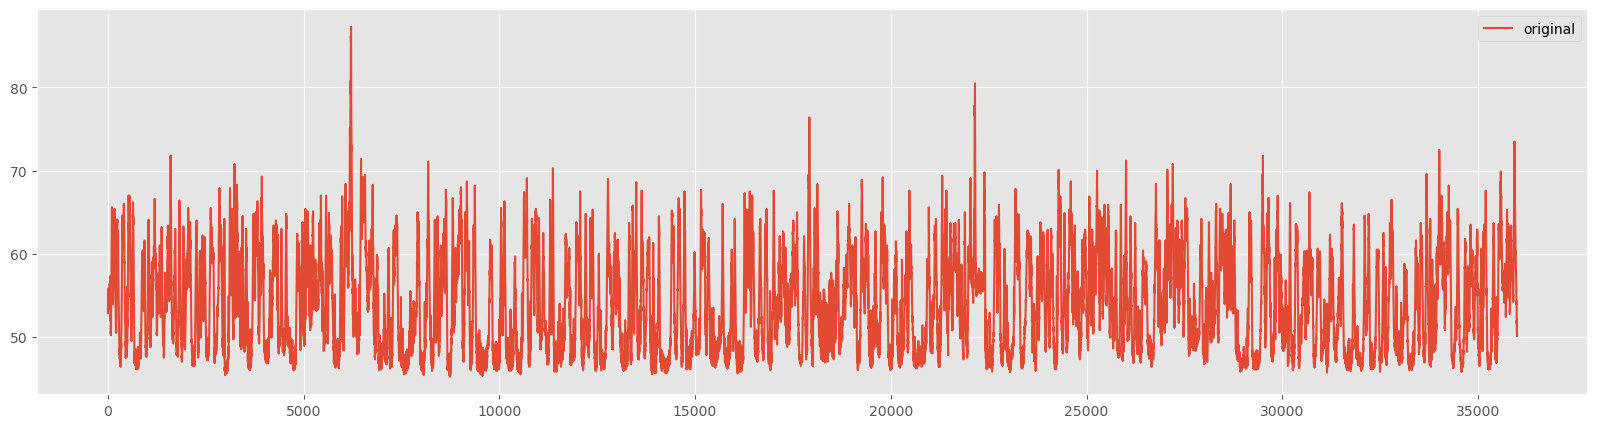

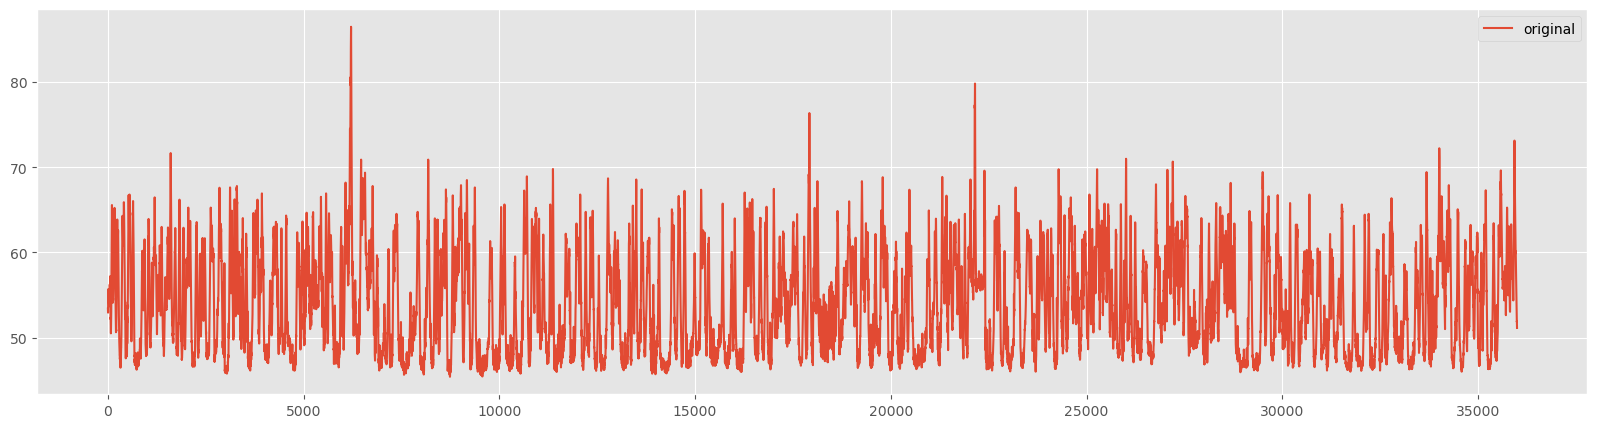

In [3]:
data = pd.read_csv( os.path.join('csv_label', 'learning_data_10.csv') )
data=data[data['day']<=0]
unit=17999
df=data.loc[:unit*2, ['original']]
label=data.loc[:unit*2, ['label']].values
df.plot()
#スムージング
df['original']=df['original'].rolling(3, min_periods=1).mean()
df.plot()

In [4]:
dataset = df['original'].values #NumPy配列へ変換
dataset = dataset.astype('float32')    #実数型へ変換
dataset

array([53.4     , 53.1     , 53.      , ..., 51.766666, 51.6     ,
       51.133335], dtype=float32)

In [5]:
dataset = np.reshape(dataset, (-1, 1)) #1次元配列を2次元配列へ変換
labelset = np.reshape(label, (-1, 1)) #1次元配列を2次元配列へ変換
print(dataset.shape, labelset.shape)

(35999, 1) (35999, 1)


In [6]:
## 分析用データセットの生成
lag_max = 100
X, y = gen_dataset(dataset, lag_max)
display(X[:8], y[:8])
print(X.shape)

array([[53.4     , 53.1     , 53.      , 52.933334, 53.2     , 53.6     ,
        54.1     , 54.8     , 55.3     , 55.633335, 55.6     , 55.7     ,
        55.7     , 55.5     , 55.2     , 54.933334, 54.9     , 54.933334,
        54.966667, 55.066666, 54.966667, 54.766666, 54.533333, 54.4     ,
        54.266666, 54.033333, 53.933334, 53.9     , 53.966667, 53.933334,
        53.966667, 53.966667, 53.933334, 53.766666, 53.7     , 53.733334,
        53.9     , 53.766666, 53.766666, 53.7     , 53.9     , 54.033333,
        54.433334, 55.      , 55.533333, 56.      , 56.166668, 56.233334,
        56.133335, 56.066666, 55.866665, 55.766666, 55.833332, 56.166668,
        56.666668, 56.966667, 57.2     , 56.733334, 56.2     , 55.633335,
        55.366665, 55.066666, 54.633335, 54.      , 53.333332, 52.6     ,
        52.233334, 52.166668, 52.366665, 52.366665, 52.033333, 51.466667,
        51.066666, 50.733334, 50.666668, 50.566666, 50.5     , 50.566666,
        50.8     , 51.166668, 51.33333

array([64.3     , 64.933334, 65.333336, 65.566666, 65.066666, 64.066666,
       63.033333, 62.466667], dtype=float32)

(35899, 100)


In [7]:
# データ分割
test_length = unit #テストデータの期間
X_train_0 = X[:-test_length,:] #学習データ
X_test_0 = X[-test_length:,:]  #テストデータ
y_train_0 = y[:-test_length] #学習データ
y_test_0 = y[-test_length:]  #テストデータ
y_train = y_train_0.reshape(-1,1)
y_test = y_test_0.reshape(-1,1)
display(y_train[:3])

array([[64.3     ],
       [64.933334],
       [65.333336]], dtype=float32)

In [8]:
# 正規化（0-1の範囲にスケーリング）
## 目的変数y
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train = scaler_y.fit_transform(y_train)
## 説明変数X
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_train_0 = scaler_X.fit_transform(X_train_0)
X_test_0 = scaler_X.transform(X_test_0)

In [9]:
print('X_train_0:',X_train_0.shape) #確認
display(X_train_0[:8]) #確認
print('------------after-------------------')
# モデル構築用にデータを再構成（サンプル数、タイムステップ, 特徴量数）
X_train = np.reshape(X_train_0, (X_train_0.shape[0],X_train_0.shape[1], 1))
X_test = np.reshape(X_test_0, (X_test_0.shape[0],X_test_0.shape[1], 1))
print('X_train:',X_train.shape) #確認
display(X_train[:8]) #確認

X_train_0: (17900, 100)


array([[0.1946472 , 0.18734789, 0.18491483, 0.18329275, 0.18978095,
        0.19951332, 0.21167874, 0.22871041, 0.24087584, 0.24898624,
        0.24817514, 0.2506082 , 0.2506082 , 0.24574208, 0.23844278,
        0.23195457, 0.2311436 , 0.23195457, 0.23276556, 0.23519862,
        0.23276556, 0.22789943, 0.22222221, 0.21897805, 0.21573389,
        0.21005666, 0.2076236 , 0.20681262, 0.2084347 , 0.2076236 ,
        0.2084347 , 0.2084347 , 0.2076236 , 0.20356846, 0.2019465 ,
        0.20275748, 0.20681262, 0.20356846, 0.20356846, 0.2019465 ,
        0.20681262, 0.21005666, 0.21978915, 0.23357654, 0.24655306,
        0.2579075 , 0.26196265, 0.26358473, 0.26115167, 0.25952947,
        0.25466335, 0.2522303 , 0.25385237, 0.26196265, 0.27412808,
        0.28142738, 0.2871046 , 0.27575016, 0.26277375, 0.24898624,
        0.24249792, 0.23519862, 0.22465527, 0.20924568, 0.19302511,
        0.17518234, 0.16626108, 0.16463912, 0.16950512, 0.16950512,
        0.16139495, 0.14760745, 0.13787508, 0.12

------------after-------------------
X_train: (17900, 100, 1)


array([[[0.1946472 ],
        [0.18734789],
        [0.18491483],
        [0.18329275],
        [0.18978095],
        [0.19951332],
        [0.21167874],
        [0.22871041],
        [0.24087584],
        [0.24898624],
        [0.24817514],
        [0.2506082 ],
        [0.2506082 ],
        [0.24574208],
        [0.23844278],
        [0.23195457],
        [0.2311436 ],
        [0.23195457],
        [0.23276556],
        [0.23519862],
        [0.23276556],
        [0.22789943],
        [0.22222221],
        [0.21897805],
        [0.21573389],
        [0.21005666],
        [0.2076236 ],
        [0.20681262],
        [0.2084347 ],
        [0.2076236 ],
        [0.2084347 ],
        [0.2084347 ],
        [0.2076236 ],
        [0.20356846],
        [0.2019465 ],
        [0.20275748],
        [0.20681262],
        [0.20356846],
        [0.20356846],
        [0.2019465 ],
        [0.20681262],
        [0.21005666],
        [0.21978915],
        [0.23357654],
        [0.24655306],
        [0

In [10]:
# モデル定義
model = Sequential()
model.add(GRU(100,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))
# コンパイル
model.compile(loss='mean_squared_error', optimizer='adam')

In [11]:
# EaelyStoppingの設定
early_stopping =  EarlyStopping(monitor='val_loss',
                                min_delta=0.0,
                                patience=2)
# 学習の実行
history = model.fit(X_train, y_train,
                    epochs=1000,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=[early_stopping] ,
                    verbose=1, 
                    shuffle=False)

Epoch 1/1000
112/112 [==============================] - 8s 61ms/step - loss: 0.0053 - val_loss: 5.4122e-04
Epoch 2/1000
112/112 [==============================] - 7s 61ms/step - loss: 9.1703e-04 - val_loss: 3.5944e-04
Epoch 3/1000
112/112 [==============================] - 7s 62ms/step - loss: 6.9943e-04 - val_loss: 2.7783e-04
Epoch 4/1000
112/112 [==============================] - 7s 60ms/step - loss: 5.6726e-04 - val_loss: 2.4091e-04
Epoch 5/1000
112/112 [==============================] - 6s 56ms/step - loss: 5.1473e-04 - val_loss: 1.9771e-04
Epoch 6/1000
112/112 [==============================] - 6s 56ms/step - loss: 4.6114e-04 - val_loss: 1.7484e-04
Epoch 7/1000
112/112 [==============================] - 6s 55ms/step - loss: 4.3773e-04 - val_loss: 1.7441e-04
Epoch 8/1000
112/112 [==============================] - 6s 55ms/step - loss: 3.9135e-04 - val_loss: 1.5102e-04
Epoch 9/1000
112/112 [==============================] - 6s 56ms/step - loss: 3.7769e-04 - val_loss: 1.4410e-04
Epoch

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 100)               30900     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________


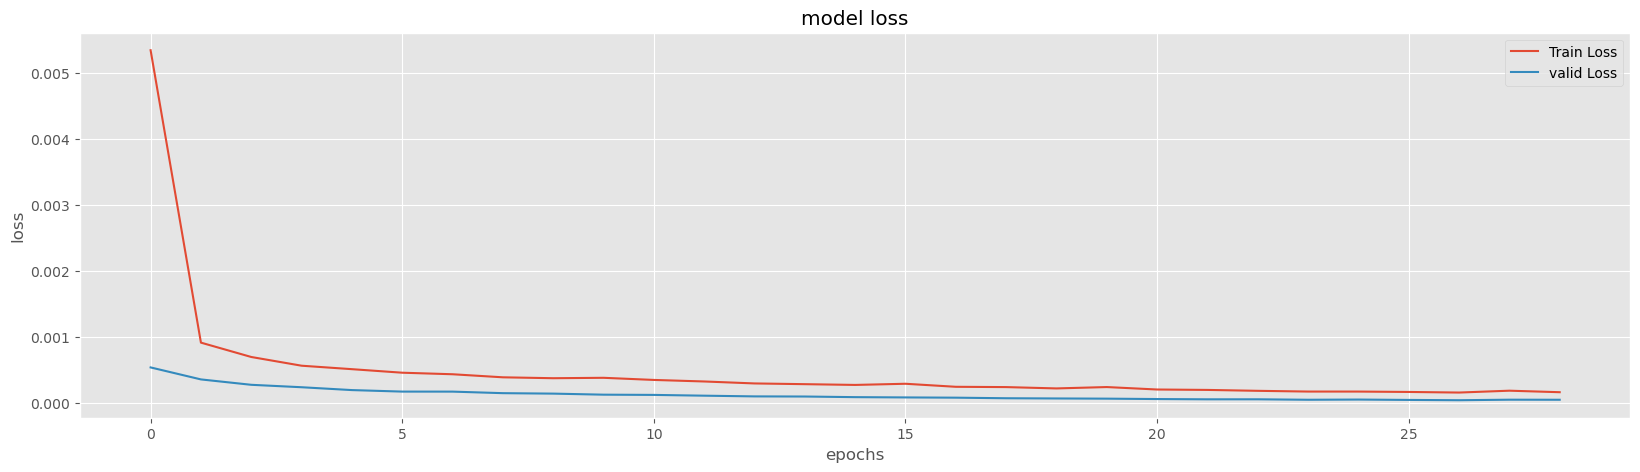

In [12]:
# 学習結果の出力
model.summary()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='valid Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

In [13]:
# テストデータの目的変数を予測
y_test_pred = model.predict(X_test)
y_test_pred = scaler_y.inverse_transform(y_test_pred)
# 指標出力
print('RMSE:')
print(np.sqrt(mean_squared_error(y_test, y_test_pred)))
print('MAE:')
print(mean_absolute_error(y_test, y_test_pred)) 
print('MAPE:')
print(mean_absolute_percentage_error(y_test, y_test_pred)) 

563/563 [==============================] - 4s 7ms/step
RMSE:
0.35966498
MAE:
0.23375282
MAPE:
0.0043021496


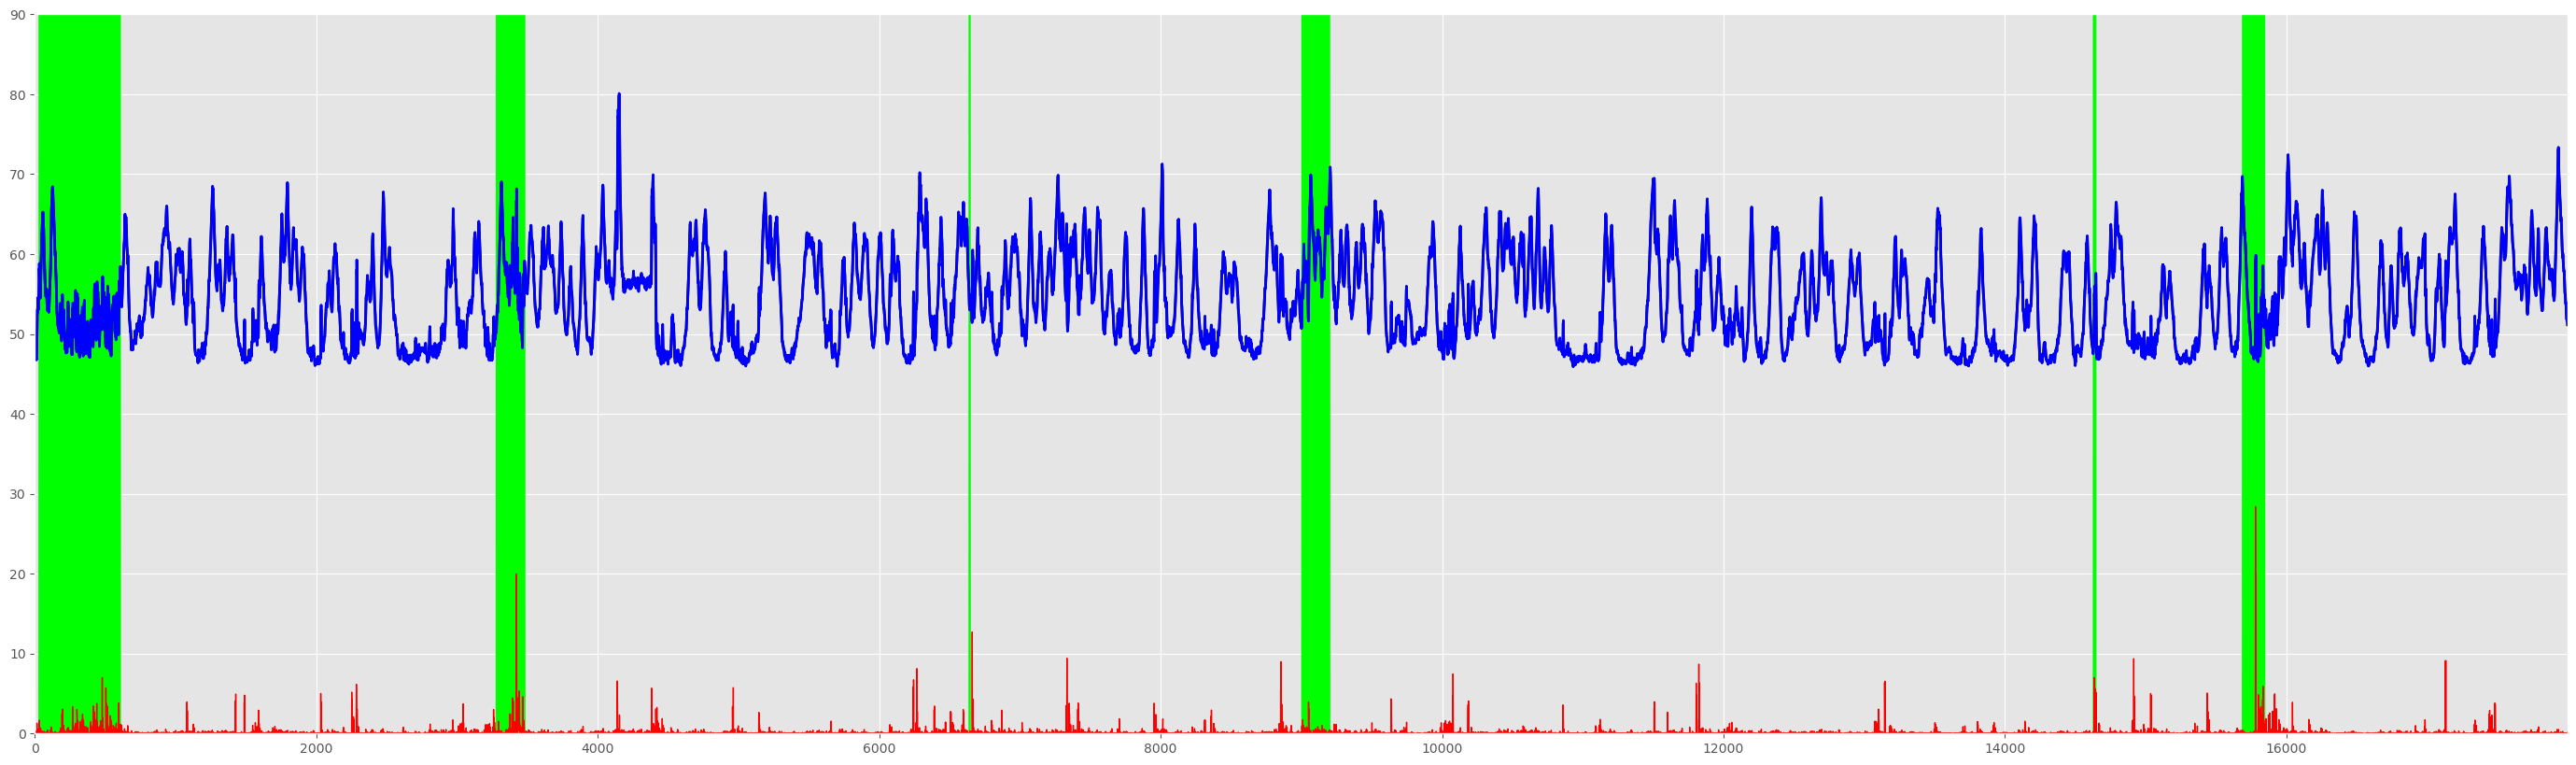

In [14]:
#異常度を計算
abnorm=(y_test_pred-y_test)**2

label=labelset.flatten()[-test_length:]*100
label_index=range(len(label))

fig = plt.figure(figsize=(35,10))
ax1 = fig.add_subplot(111)
ax1.plot(abnorm, '-r',linewidth = 1 )
ax1.plot(y_test, '-k',linewidth = 2)
ax1.plot(y_test_pred, '-b',linewidth = 2)
ax1.fill_between(label_index, label, facecolor='lime' )
plt.xlim(0,17999)
plt.ylim(0, 90)
plt.show()